In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import pulse,schedule
from qiskit.pulse import Schedule

In [3]:
import matplotlib.pyplot as plt
import datetime
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, sigmam, tensor
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
from qutip.qip.operations.gates import rx,sqrtnot
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

importing the Hamiltonian parameters from qiskit

In [4]:
token= '023f373dc54c121ed029051e578c1c639af5bb83bbd20f56acdbbdfae0faf3782ff72329750d32853370939170a2ddf7785f1f31550186921b0351abf7cdb128'
provider = IBMQ.enable_account(token,hub='ibm-q-bnl', group='bnl-non-c2qa-pro', project='physics-guided-o')

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
backend = provider.get_backend('ibmq_bogota')

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
backend_defaults = backend.defaults(backend)
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
props = backend.properties()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
qubit = 2

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
w0 = backend_defaults.qubit_freq_est[qubit]/GHz

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#The Hamiltoninan model
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)

sx_gate = sqrtnot()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
H0 = 0.5*w0*Sz
Hc = [Sx]#,Sy,Sz]

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
t1 = props.t1(qubit)
t2 = props.t2(qubit)

In [ ]:
t1

In [ ]:
gamma1=(1/t1)/GHz
gamma2=(1/t2)/GHz

In [ ]:
gamma1

In [ ]:
L0 = liouvillian(H0,[np.sqrt(gamma1)*Sm])

In [ ]:
#sigma X control
LC_x = liouvillian(Sx)
#sigma Y control
LC_y = liouvillian(Sy)
#sigma Z control
LC_z = liouvillian(Sz)

#Drift
drift = L0
#Controls - different combinations can be tried
ctrls = [LC_x, LC_y, LC_z]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(Si, Si)

# target for map evolution
E_targ = sprepost(sx_gate, sx_gate)

In [13]:
# Time allowed for the evolution
evo_time = 160
# Number of time slots
n_ts = int(float(evo_time/0.222))
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 1000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20
p_type = 'DRAG'
#Run optimization
#result = cpo.optimize_pulse(drift, ctrls, E0, E_targ, n_ts, evo_time,amp_lbound=0, amp_ubound=1, 
#                fid_err_targ=fid_err_targ, min_grad=min_grad, 
#                max_iter=max_iter, max_wall_time=max_wall_time, 
#                out_file_ext=None, init_pulse_type=p_type, 
#                log_level=log_level, gen_stats=True)
result=cpo.optimize_pulse_unitary(H0, Hc, Si, sx_gate, n_ts, evo_time,
                             amp_lbound=0,amp_ubound=1,
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=None, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 2.39145141  0.        ]
 [ 0.   


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.812533
Wall time computing Hamiltonians: 0:00:00.027054 (3.33%)
Wall time computing propagators: 0:00:00.583922 (71.86%)
Wall time computing forward propagation: 0:00:00.006924 (0.85%)
Wall time computing onward propagation: 0:00:00.006830 (0.84%)
Wall time computing gradient: 0:00:00.041554 (5.11%)

**** Iterations and function calls ****
Number of iterations: 4
Number of fidelity function calls: 10
Number of times fidelity is computed: 10
Number of gradient function calls: 9
Number of times gradients are computed: 9
Number of times timeslot evolution is recomputed: 10

**** Control amplitudes ****
Number of control amplitude updates: 9
Mean number of updates per iteration: 2.25
Number of timeslot values changed: 6289
Mean number of timeslot changes per update: 698.7777777777778
Number of amplitude values changed: 6289
Mean num

# Qiskit part

In [14]:
x = result.final_amps.T[0]
#y = result.final_amps.T[1]
#z = result.final_amps.T[2]

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from qiskit.pulse import (Acquire, AcquireChannel, ControlChannel, Delay, 
                          DriveChannel, MeasureChannel, MemorySlot, Play,
                          Schedule, ShiftPhase, Waveform,build)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)    

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
Ncx = get_closest_multiple_of_16(len(x))
#Ncy = get_closest_multiple_of_16(len(y))
#Ncz = get_closest_multiple_of_16(len(z))

padded_pulsex = [0 for i in range(Ncx+16)]
#padded_pulsey = [0 for i in range(Ncy+16)]
#padded_pulsez = [0 for i in range(Ncz+16)]

#padded_pulsey[0:len(y)] = y
padded_pulsex[0:len(x)] = x
#padded_pulsez[0:len(z)] = z

with build(name='sx') as sx_q0:
    pulse.play(Waveform(padded_pulsex),DriveChannel(qubit))
    #pulse.play(Waveform(padded_pulsey),DriveChannel(qubit))
    #pulse.play(Waveform(padded_pulsez),DriveChannel(qubit))
    

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
cals = backend.defaults().instruction_schedule_map
basis_gates = backend_config.basis_gates
basis_gates += ['my_1q']
cals.add('my_1q',(qubit),sx_q0)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from qiskit.circuit import Gate
sx1 = Gate('my_1q',num_qubits=1,params=[])


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


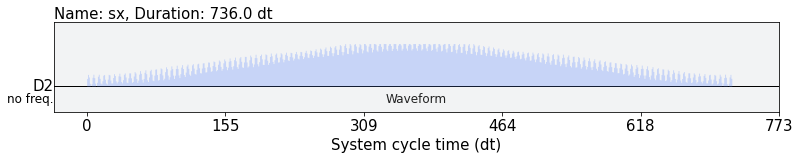

In [20]:
cals.get('my_1q',[qubit]).draw()

# Error Mitigation

In [ ]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [ ]:
qr = QuantumRegister(1)
qubit_list=[0]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [ ]:
t_qc = transpile(meas_calibs,backend)

In [ ]:
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [ ]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

In [22]:
qr = QuantumRegister(3)
cr = qiskit.ClassicalRegister(3)
circ = QuantumCircuit(qr,cr)
circ.append(sx1,[qubit])
circ.rz(-np.pi/4,2)
circ.measure(qr[qubit],cr[0])
circ.draw()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


q1_0: ────────────────────────
                              
q1_1: ────────────────────────
      ┌───────┐┌──────────┐┌─┐
q1_2: ┤ my_1q ├┤ RZ(-π/4) ├┤M├
      └───────┘└──────────┘└╥┘
c1: 3/══════════════════════╩═
                            0

In [23]:
dt = backend.configuration().dt
from qiskit import transpile, schedule as build_schedule
tcirc = transpile(circ,backend,basis_gates)
schedule1 = schedule(tcirc, backend, inst_map=cals)

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


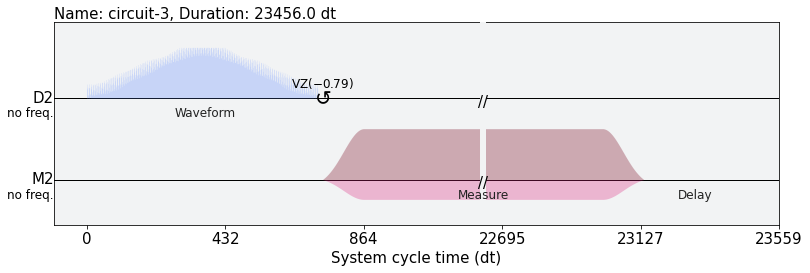

In [24]:
schedule1.draw()

In [25]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
sx_job = execute([schedule1],backend,meas_level=2,shots=1048).result()

/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [27]:
# Results without mitigation
raw_counts = sx_job.get_counts()



/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/elishasiddiqui/.conda/envs/qutip_clone_test/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


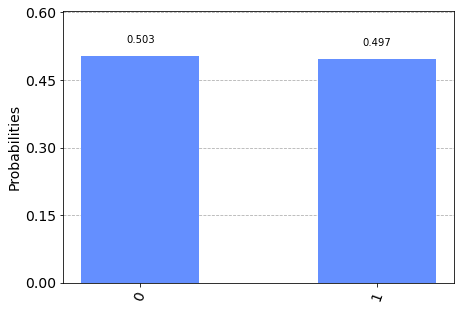

In [28]:
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
plot_histogram(marginal_counts(raw_counts, [0,0], format_marginal=True))

In [ ]:
# Get the filter object
#build a fitter from the subset
meas_fitter_sub = meas_fitter.subset_fitter(qubit_sublist=[qubit])

In [ ]:
meas_filter_sub = meas_fitter_sub.filter


# Results with mitigation
mitigated_results = meas_filter_sub.apply(sx_job)
mitigated_counts = mitigated_results.get_counts(0)

In [ ]:
from qiskit.result.utils import marginal_counts
from qiskit.visualization import plot_histogram
plot_histogram([marginal_counts(raw_counts,[0,0]), marginal_counts(mitigated_counts,[0,0])], legend=['raw', 'mitigated'])

In [ ]:
#from qiskit.result.utils import marginal_counts
#from qiskit.visualization import plot_histogram
#plot_histogram(marginal_counts(had_job.get_counts(), [0,0], format_marginal=True))

In [ ]:
import qiskit
qiskit.__qiskit_version__